In [100]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [101]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
#Fonction permettant d'échantilloner selon les lois
from numpy.random import dirichlet, normal, gamma
from scipy.stats import multivariate_normal as mult_norm, norm, invgamma

from functools import partial
from progressbar import ProgressBar
import time
%matplotlib inline

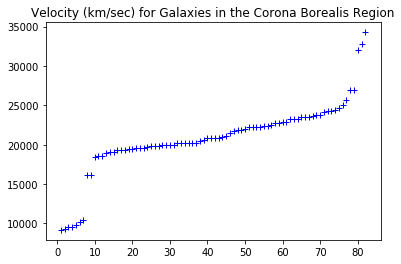

In [102]:
data = pd.read_csv('galaxy.csv', index_col=0)
y= data.iloc[:,0].values/1000
plt.plot(data.iloc[:,0],'b+', label="Velocity")
plt.title("Velocity (km/sec) for Galaxies in the Corona Borealis Region")
plt.show()

### Le but de cette étude est de trouver le nombre de clusters définissant la distribution des vitesses des étoiles dans la région de la [couronne boréale](https://fr.wikipedia.org/wiki/Couronne_bor%C3%A9ale)

Cet article propose d'estimer la distribution marginale $p(y)$ de la vraisemblance $L(y ;\theta)$. Pour celà, des estimateurs basés sur des échantillons obtenus par un échantilloneur de Gibbs sont utilisés. 
Dans notre exemple, on suppose que les données sont distribuées selon un modèle de mélange avec k groupes. Le modèle est défini comme suit. 
Priors du modèle
$$
\mu_j \sim \mathcal{N}(\mu_0 , phi)\\
\sigma_j \sim \mathcal{IG}(\frac{v_0}{2}, \frac{\delta_0}{2})\\
q \sim Dirichlet(\alpha_1, ..., \alpha_d)
$$
où d = nombre de clusters considérés (2 ou 3)

$\mu_0 = 20, \ A^{-1} = 100, \ v_0 = 6, \ \delta_0 = 40,\ \alpha_j = 1$

In [103]:
def normal_update(n_clust, clust_mean, sigma, sigma0=100,mu0=20,v0=6, delta0=40):   
    ### Mean & var posterior de mu
    mu_mean_up = np.divide(n_clust*clust_mean* sigma0 + mu0 * sigma , sigma0 *n_clust + sigma )
    mu_var_up = np.divide(sigma0  * sigma, sigma0 * n_clust + sigma)

    return mu_mean_up, mu_var_up

def dirichlet_update(a, n_clust):
    return a + n_clust

def InvGamma_update(n_clust, delta, v0=6, delta0= 40):
    ### Paramètre de la loi posterieure de sigma
    v_up = v0 +n_clust
    delta_up = delta + delta0
    return v_up, delta_up

def z_update(q, mu, sigma, y, nb_clust=3):
    #retourne les probabilités q[j] d'être dans le cluster j
    return np.array([ q[i]*mult_norm.pdf(x=y,mean=mu[i],cov=sigma[i]) for i in range(nb_clust)]).T
                  


In [104]:
#Initalisation des paramètres
nb_clust = 3
z=np.random.randint(0,nb_clust,size=(1,y.shape[0]))


clust ,n_clust = np.unique(z[-1], return_counts=True)

if(clust.shape[0] < nb_clust):
    print("ERROR - PAS ASSEZ DE CLUSTEURS LORS DE L'INITALISATION ALEATOIRE")
    
mu0= 20
A0 = 100
v0 = 6
delta0 = 40
alpha = np.ones(nb_clust)
sigma0 = 1

q0 = np.ones(nb_clust)

#Calcul des quantités nécessaires pour la mise à jour des paramètres : moyenne intra clust et mse intra clust
delta, clust_mean= [],[]
for i in range(nb_clust):
    delta.append(np.sum(np.square(y[z[-1]==i]-mu0)))
    clust_mean.append(np.mean(y[z[-1]==i]))
delta, clust_mean = np.array(delta), np.array(clust_mean)

#Mise à jour de la moyenne mu
mu_mean_up, mu_var_up = normal_update(n_clust, clust_mean, sigma=sigma0)
mu_sample = normal(loc = mu_mean_up, scale = np.sqrt(mu_var_up))
#y_mse = [np.sum(np.square( y[z[-1]==i] - mu_mean_up[i] )) for i in range(nb_clust)]

#Mise à jour de la variance sigma
v_up, delta_up = InvGamma_update(n_clust, delta)
sigma_sample = 1/gamma(v_up/2, 2/delta_up) # Est-ce correcte ou faut-il inverser le deuxième paramètre ? 

### Mise à jour de la proba q
alpha_up = dirichlet_update(alpha , n_clust)
q = dirichlet(alpha_up)

#Mise à jour des probas de chaque cluster
q_up = z_update(q, mu_sample, sigma_sample,y)
q_up = q_up/q_up.sum(axis=1, keepdims=True)
z_sample= np.array([np.random.choice(range(nb_clust), p=q_up[i]) for i in range(y.shape[0])])

mu_sample = mu_sample.reshape(1, mu_sample.shape[0])
sigma_sample = sigma_sample.reshape(1, sigma_sample.shape[0])
z_sample = z_sample.reshape(1, z_sample.shape[0])

In [105]:
n_iter = 2000
bar = ProgressBar(maxval=n_iter)
bar.start()
for k in range(n_iter):
        #Calcul des quantités nécessaires pour la mise à jour des paramètres : moyenne intra clust et mse intra clust
    clust ,n_clust = np.unique(z_sample[-1], return_counts=True)
    delta, clust_mean= [],[]
    for i in range(nb_clust):
        delta.append(np.sum(np.square(y[z_sample[-1]==i]-mu_sample[-1][i])))
        clust_mean.append(np.mean(y[z_sample[-1]==i]))
    delta, clust_mean = np.nan_to_num(delta), np.nan_to_num(clust_mean)

    #Mise à jour de la moyenne mu
    mu_mean_up, mu_var_up = normal_update(n_clust, clust_mean, sigma=sigma_sample[-1][i])
    mu_sample = np.vstack((mu_sample, normal(loc = mu_mean_up, scale = mu_var_up)))
    #y_mse = [np.sum(np.square( y[z[-1]==i] - mu_mean_up[i] )) for i in range(nb_clust)]

    #Mise à jour de la variance sigma
    v_up, delta_up = InvGamma_update(n_clust, delta)
    #sigma_sample = np.vstack((sigma_sample, 1/gamma(v_up/2, 2/delta_up))) # Est-ce correcte ou faut-il inverser le deuxième paramètre ? 
    sigma_sample = np.vstack((sigma_sample, invgamma.rvs(v_up/2, scale= delta_up/2))) # Est-ce correcte ou faut-il inverser le deuxième paramètre ? 

    ### Mise à jour de la proba q
    alpha_up = dirichlet_update(alpha , n_clust)
    q = dirichlet(alpha_up)
    
    #Mise à jour des probas de chaque cluster
    q_tmp= z_update(q_up[-1], mu_sample[-1], sigma_sample[-1],y)
    q_tmp = np.nan_to_num(q_tmp)
    q_up = np.vstack((q_up, np.divide(q_tmp,q_tmp.sum(axis=1, keepdims=True))))
    z_sample= np.vstack((z,np.array([np.random.choice(range(nb_clust), p=q_up[i]) for i in range(y.shape[0])])))
    bar.update(k)
bar.finish()

100% (2000 of 2000) |####################| Elapsed Time: 0:00:19 Time:  0:00:19


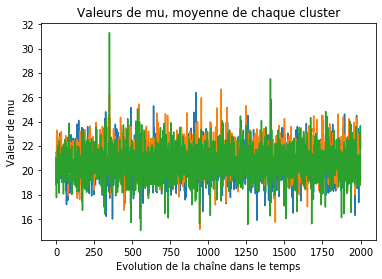

In [106]:
plt.plot(mu_sample)
plt.title('Valeurs de mu, moyenne de chaque cluster')
plt.xlabel('Evolution de la chaîne dans le temps')
plt.ylabel('Valeur de mu')
plt.show()

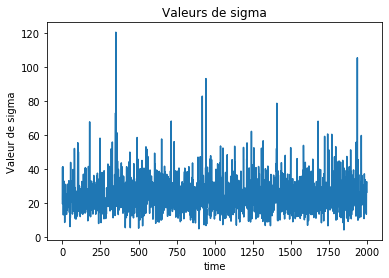

In [109]:
plt.plot(sigma_sample[:,2])
plt.title("Valeurs de sigma")
plt.xlabel('time')
plt.ylabel('Valeur de sigma')
plt.show()

In [110]:
def Log_likelihood(q, mu, sigma):
    #Prend un seul y, calcul la densité pour chaque cluster et pondère par la proba du cluster
    #INPUT : q = dimension 3, proba de chaque cluster
    #       mu = dimension 3, moyenne de chaque cluster
    #    sigma = dimension 3, var de chaque cluster
    return np.log(list(map(lambda i: np.exp(np.log(q)+np.log(list(map(norm.pdf,y[i]*np.ones(3), mu, np.sqrt(sigma))))).sum(), range(y.shape[0])))).sum()

In [121]:
def Log_likelihood_wrapper(i):
    return Log_likelihood(q=q_up[i], mu=mu_sample[i], sigma =sigma_sample[i])

In [123]:
### On utilise le maximum de vraisemblance, même si ce n'est pas nécessaire,
### celà permet des calculs plus stable, c.f article

#f = np.vectorize(Log_likelihood)
#t = np.argmax(f,  q_up,mu_sample,sigma_sample)
t = np.argmax( np.array(list(map(Log_likelihood_wrapper, range(2000) ))) )

In [125]:
mu_star, sigma_star, q_star = mu_sample[t], sigma_sample[t], q_up[t]

In [ ]:
### Calcul du premier bloc : 
### log_vraisemblance + log prior - log( posterior( mu ))

def log_prior(mu,sigma,q):
    #Les paramètres sont à priori indépendants donc :
    np.log()